In [1]:
pip install gym==0.26.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827621 sha256=02f8ac144abe1b25fd294d4dc3d224287efadff9f5c4dd0f2949b7f0291ae095
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [2]:
pip show gym

Name: gym
Version: 0.26.2
Summary: Gym: A universal API for reinforcement learning environments
Home-page: https://www.gymlibrary.dev/
Author: Gym Community
Author-email: jkterry@umd.edu
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: cloudpickle, gym-notices, numpy
Required-by: dopamine-rl


In [3]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
#from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
import random
import seaborn as sns

303
Number of states: 500
Number of actions that an agent can take: 6
Action taken: east
Transition probability: False
Next state: 303
Reward recieved: -1
Terminal state: False


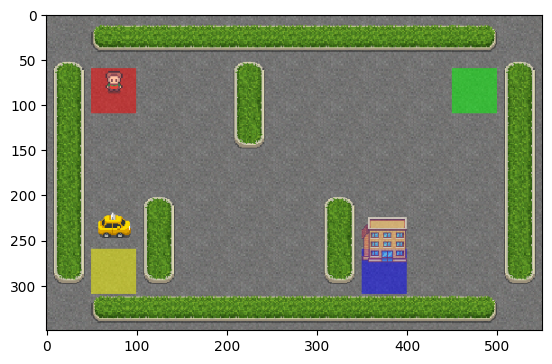

In [31]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different.
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
env = gym.make('Taxi-v3', render_mode='rgb_array')
state = env.reset()

#Current State
print(env.s)

# 25 * 5 * 4 = 500 states
print ("Number of states:", env.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 5)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob,_ = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

env_image = env.render()
plt.imshow(env_image)

303
Decoded state: [3, 0, 0, 3]
303  = (([3]*5 + [0])*5 + [0])*4 + [3]


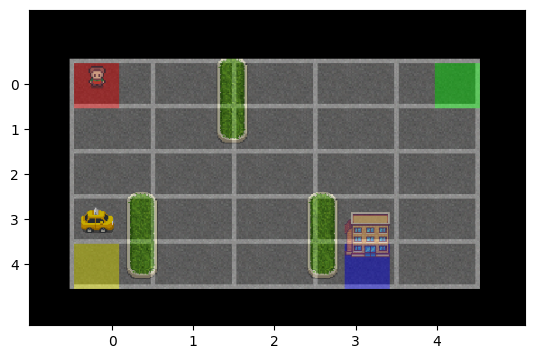

In [32]:
'''
Just plotting the image for better visualization
'''

boxes = np.zeros(env_image.shape)

for i in range(6):                    # Creating an array to plot grid states accurately
  boxes[55+50*i:60+50*i,50:500]=1
  boxes[55:310,45+90*i:50+90*i]=1

env_image[:55]=0
env_image[310:]=0
env_image[:,:45]=0
env_image[:,500:]=0

plt.imshow(env_image)
plt.imshow(boxes, alpha=0.2)

custom_xticks =  [92, 182, 272, 362, 452]
custom_xticklabels = [0,1,2,3,4]
plt.xticks(custom_xticks, custom_xticklabels)
custom_yticks = [82, 132, 182, 232, 282]
custom_yticklabels = [0,1,2,3,4]
plt.yticks(custom_yticks, custom_yticklabels)


decoded_state = list(env.decode(state[0]))
print(state[0])
print("Decoded state:", decoded_state)
print(state[0],' = (([%d]*5 + [%d])*5 + [%d])*4 + [%d]'%(decoded_state[0],decoded_state[1],decoded_state[2],decoded_state[3]))

In [7]:
def egreedy_policy(q_values,state,epsilon, total_options):
    '''
    Function for ε-greedy action selection
    '''
    if np.random.rand() < epsilon:
        action = np.random.randint(len(total_options))
    else:
        action = np.argmax(q_values[state])
    return action

In [8]:
def matching_options(state, action, rgyb_policy_dict):
    '''
    Helper function to return options (including the selected action) which would have selected the same action
    Used for IOQL updates
    '''
    additional_options = [action]       # Include the selected action
    row = list(env.decode(state))[0]
    col = list(env.decode(state))[1]
    pos = (row, col)                    # State indices
    for i in [6,7,8,9]:
        if rgyb_policy_dict[i][row][col] == action:     # Check which options would have selected the same action
            additional_options.append(i)
    return additional_options

def terminating_cond(state, option, rgyb_loc_dict):
    '''
    Another helper function to check the terminating condition
    Used for IOQL updates
    '''
    row = list(env.decode(state))[0]
    col = list(env.decode(state))[1]
    pos = (row, col)                    # State indices
    if option < 6:
        terminating = True              # Always terminate after single-step (primitive option)
    else:
        if pos == rgyb_loc_dict[option]:
            terminating = True          # Terminate if location is the goal location for the chosen option
        else:
            terminating = False         # Don't terminate
    return terminating

In [9]:
def visualize_q_values(q_values):
    '''
    Function to visualize Q-Table
    '''
    z = np.zeros((500,2))
    for i in range(500):
        arg = np.argmax(q_values[i])
        z[i,0] = q_values[i,arg]
        z[i,1] = arg

    y = np.zeros((4,5,5,5,2))
    for i in range(4):
        for j in range(5):
            for k in range(5):
                for l in range(5):
                    for m in range(2):
                        y[i,j,k,l,m] = z[(5*(5*k+l)+j)*4+i,m]

    action_dict = {0 : 'S', 1 : 'N', 2 : 'E', 3: 'W', 4: 'Pick', 5: 'Drop', 6: 'Opt_R', 7: 'Opt_G', 8:'Opt_Y', 9:'Opt_B'}
    dest_dict = {0: 'Red', 1: 'Green', 2:'Yellow', 3: 'Blue'}
    pass_dict = {0: 'Red', 1: 'Green', 2:'Yellow', 3: 'Blue', 4: 'Taxi'}
    fig, axes = plt.subplots(5,4, figsize = (20,16))


    for i in range(5):
        for j in range(4):
            a = sns.heatmap(y[j,i,:,:,0], annot = [[action_dict[num] for num in row] for row in y[j,i,:,:,1]], fmt="", ax=axes[i][j], xticklabels=False, yticklabels=False, cmap='viridis')
            a.set_title('Passenger at '+ pass_dict[i] + ' and Destination at ' + dest_dict[j])
            for k in range(5):
                a.axhline(y=k , color='black', linewidth=0.5)
                a.axvline(x=k , color='black', linewidth=0.5)


## Defining Options:

In [10]:
class Options():
    def __init__(self, total_options, rgyb_loc_dict, rgyb_policy_dict):
        self.total_options = total_options
        self.option_size = len(total_options)
        self.rgyb_loc_dict = rgyb_loc_dict
        self.rgyb_policy_dict = rgyb_policy_dict

    def check_option_execution(self, state, option, env):
        '''
        ->Checks if a selected options needs to executed
        ->It need not execute if the taxi is already there at the location
        '''
        taxi_pos1 = list(env.decode(state))[0]
        taxi_pos2 = list(env.decode(state))[1]
        taxi_pos = (taxi_pos1, taxi_pos2)             # Taxi location
        if taxi_pos != self.rgyb_loc_dict[option]:
            return True
        else:
            return False

    def execute_option_SMDP(self, state, option, env, gamma):
        '''
        Multi-step option execution (SMDP)
        '''
        state_t = np.copy(state)
        tau = 0
        reward_bar = 0
        optdone = False
        while (optdone == False):
            taxi_pos1 = list(env.decode(state))[0]
            taxi_pos2 = list(env.decode(state))[1]
            optact = self.rgyb_policy_dict[option][taxi_pos1][taxi_pos2]
            next_state, reward, done, _,_ = env.step(optact)
            reward_bar = gamma * reward_bar + reward
            tau += 1
            state = next_state
            next_taxi_pos1 = list(env.decode(state))[0]
            next_taxi_pos2 = list(env.decode(state))[1]
            next_taxi_pos = (next_taxi_pos1, next_taxi_pos2)
            if next_taxi_pos == self.rgyb_loc_dict[option]:
                optdone = True
                state_t_plus_tau = state
        return state_t, state_t_plus_tau, reward_bar, tau, done

    def execute_option_IOQL(self, q_values_IOQL, state, option, env, alpha, gamma):
        '''
        Multi-step option execution (IOQL)
        '''
        state_t = np.copy(state)
        tau = 0
        reward_bar = 0
        optdone = False
        while (optdone == False):
            taxi_pos1 = list(env.decode(state))[0]
            taxi_pos2 = list(env.decode(state))[1]
            optact = self.rgyb_policy_dict[option][taxi_pos1][taxi_pos2]
            next_state, reward, done, _,_ = env.step(optact)

            additional_options = matching_options(state, optact, self.rgyb_policy_dict)     # would contain additional options from [6,7,8,9]
            for additional_option in additional_options:
                terminating = terminating_cond(state, additional_option, self.rgyb_loc_dict)    # IOQL Update
                if terminating:       # check terminating condition and perform update accordingly
                    q_values_IOQL[state, additional_option] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, additional_option])
                else:
                    q_values_IOQL[state, additional_option] += alpha * (reward + gamma * q_values_IOQL[next_state, additional_option] - q_values_IOQL[state, additional_option])

            reward_bar = gamma * reward_bar + reward
            tau += 1
            state = next_state
            next_taxi_pos1 = list(env.decode(state))[0]
            next_taxi_pos2 = list(env.decode(state))[1]
            next_taxi_pos = (next_taxi_pos1, next_taxi_pos2)
            if next_taxi_pos == self.rgyb_loc_dict[option]:
                optdone = True
                state_t_plus_tau = state

        return state_t, state_t_plus_tau, reward_bar, tau, done


In [11]:
total_options = ["South", "North", "East", "West", "Pick", "Drop", "Option Red", "Option Green", "Option Yellow", "Opt Blue"]

# Locations of goals R, G, Y and B (indices)
rgyb_loc_dict = {6: (0,0), 7: (0,4), 8: (4,0), 9:(4,3)}

# Deterministic policy for options to reach goals
rgyb_policy_dict = {6: np.array([[1,3,0,0,0],
                              [1,3,0,0,0],
                              [1,3,3,3,3],
                              [1,1,1,1,1],
                              [1,1,1,1,1]]),

                 7: np.array([[0,0,2,2,1],
                              [0,0,2,2,1],
                              [2,2,2,1,1],
                              [1,2,1,1,1],
                              [1,2,1,1,1]]),
                 8: np.array([[0,3,0,0,0],
                              [0,3,0,0,0],
                              [0,3,3,3,3],
                              [0,1,1,1,3],
                              [0,1,3,1,3]]),
                 9: np.array([[0,0,0,0,3],
                              [0,0,0,0,3],
                              [2,2,2,0,3],
                              [1,1,1,0,3],
                              [1,1,1,0,3]])}

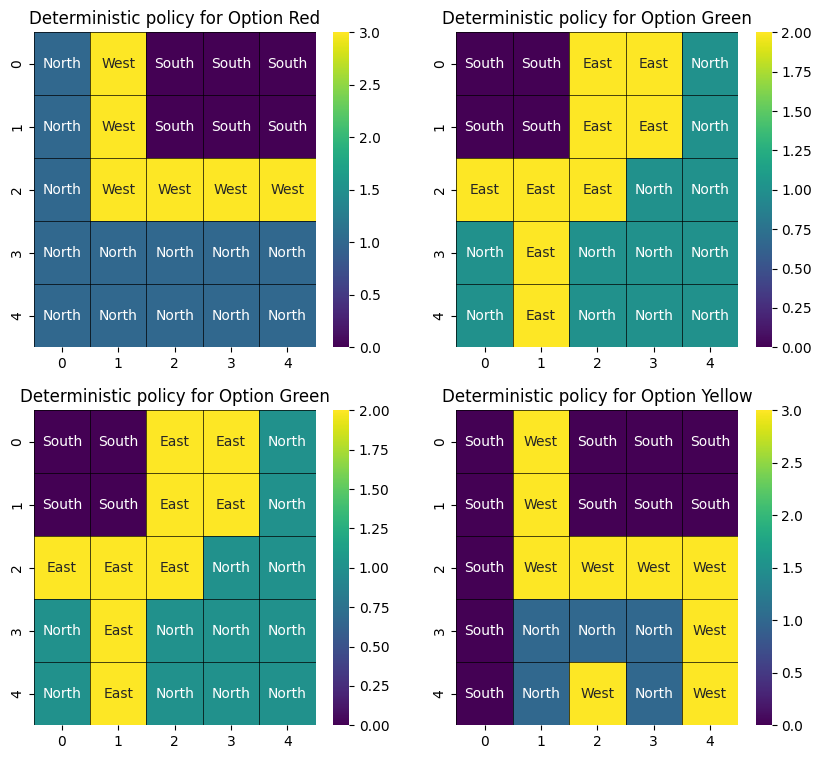

In [12]:
fig, axes = plt.subplots(2,2,figsize = (10,9))

for i in range(2):
    for j in range(2):
        a = sns.heatmap(rgyb_policy_dict[i+j+6], annot = [[total_options[num] for num in row] for row in rgyb_policy_dict[i+j+6]], ax = axes[i][j],fmt="",cmap='viridis')
        a.set_title('Deterministic policy for '+total_options[i+j+6])
        for k in range(5):
          a.axhline(y=k , color='black', linewidth=0.5)
          a.axvline(x=k , color='black', linewidth=0.5)

## SMDP Q-Learning :

In [19]:
class SMDP_QL():
    def __init__(self, total_options, options_object, num_of_episodes, policy, epsilon, gamma, alpha):
        self.total_options = total_options
        self.options_object = options_object
        self.num_of_episodes = num_of_episodes
        self.policy = policy
        self.epsilon = epsilon        # Parameters
        self.gamma = gamma
        self.alpha = alpha

    def run(self):

        state_size = env.observation_space.n                # 500
        option_size = len(self.total_options)               # 10
        q_values_SMDP = np.zeros((state_size, option_size))
        rewards_SMDP = np.zeros(self.num_of_episodes)

        for i in tqdm(range(self.num_of_episodes)):
            state = env.reset()[0]
            done = False
            episodic_reward = 0
            while not done:
                action = self.policy(q_values_SMDP, state, self.epsilon, self.total_options)      # Choose action
                if action < 6:
                    # Perform regular Q-Learning update for state-action pair
                    next_state, reward, done, _, _ = env.step(action)
                    q_values_SMDP[state, action] += self.alpha * (reward + self.gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, action])
                    episodic_reward += reward
                    state = next_state
                else:
                    # Perform multi-step option update
                    if self.options_object.check_option_execution(state, action, env):
                        state_t, state_t_plus_tau, reward_bar, tau, done = self.options_object.execute_option_SMDP(state, action, env, self.gamma)
                        q_values_SMDP[state_t, action] += self.alpha * (reward_bar + (self.gamma)**tau * np.max(q_values_SMDP[state_t_plus_tau]) - q_values_SMDP[state_t, action])
                        episodic_reward += reward_bar
                        state = state_t_plus_tau
            rewards_SMDP[i] = episodic_reward
        return q_values_SMDP, rewards_SMDP

In [14]:
options_object = Options(total_options, rgyb_loc_dict, rgyb_policy_dict)
num_of_episodes = 2000
policy = egreedy_policy
gamma = 0.9

100%|██████████| 2000/2000 [00:05<00:00, 365.54it/s]


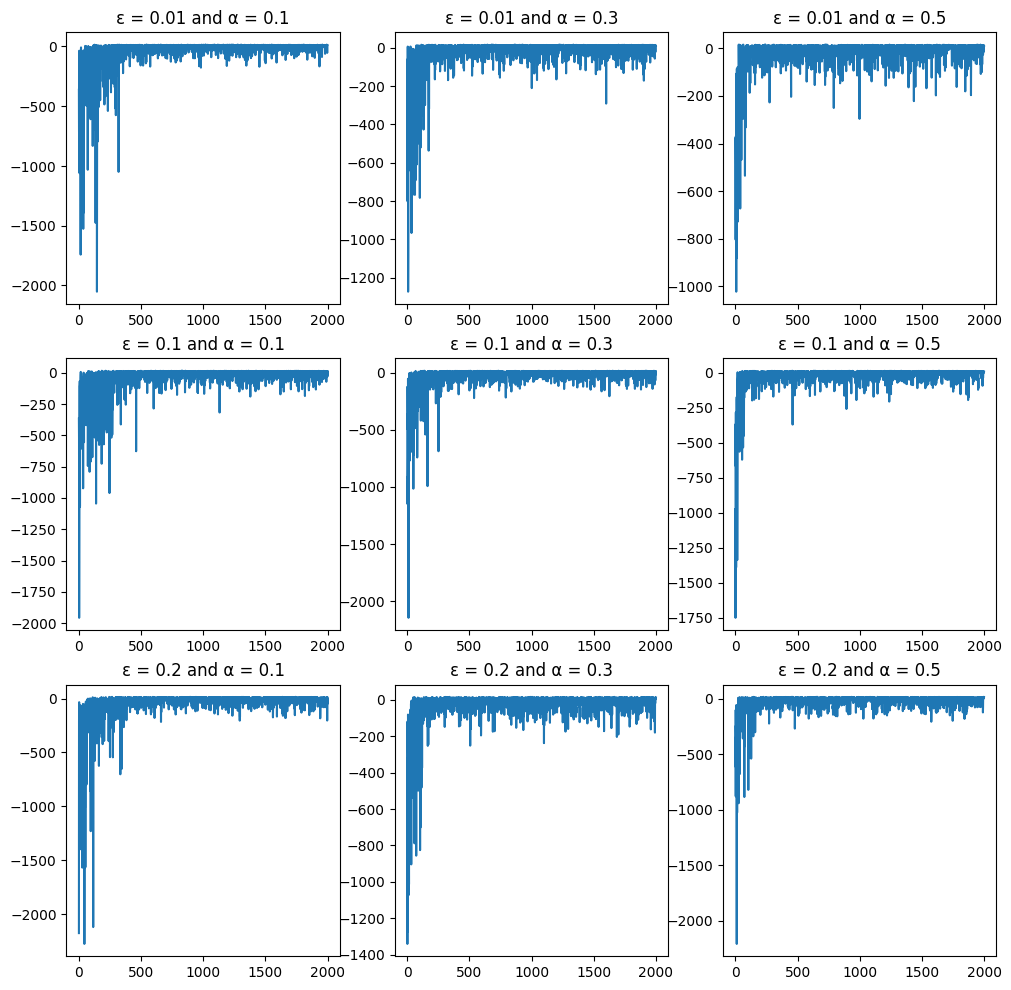

In [20]:
# Hyperparameter tuning for SMDP
epsilon_values = [0.01, 0.1, 0.2]
alpha_values = [0.1, 0.3, 0.5]
rewards_tuning_SMDP = []
qvalues_tuning_SMDP = []
fig, axes = plt.subplots(3,3, figsize=(12,12))

for (eps,i) in zip(epsilon_values, range(3)):
    for (alp,j) in zip(alpha_values, range(3)):
        smdp = SMDP_QL(total_options, options_object, num_of_episodes, policy, eps, gamma, alp)
        q_values_SMDP, rewards_SMDP = smdp.run()
        qvalues_tuning_SMDP.append(q_values_SMDP)
        rewards_tuning_SMDP.append(rewards_SMDP)
        axes[i][j].plot(rewards_SMDP)
        axes[i][j].set_title('ε = '+str(eps)+' and α = '+str(alp))

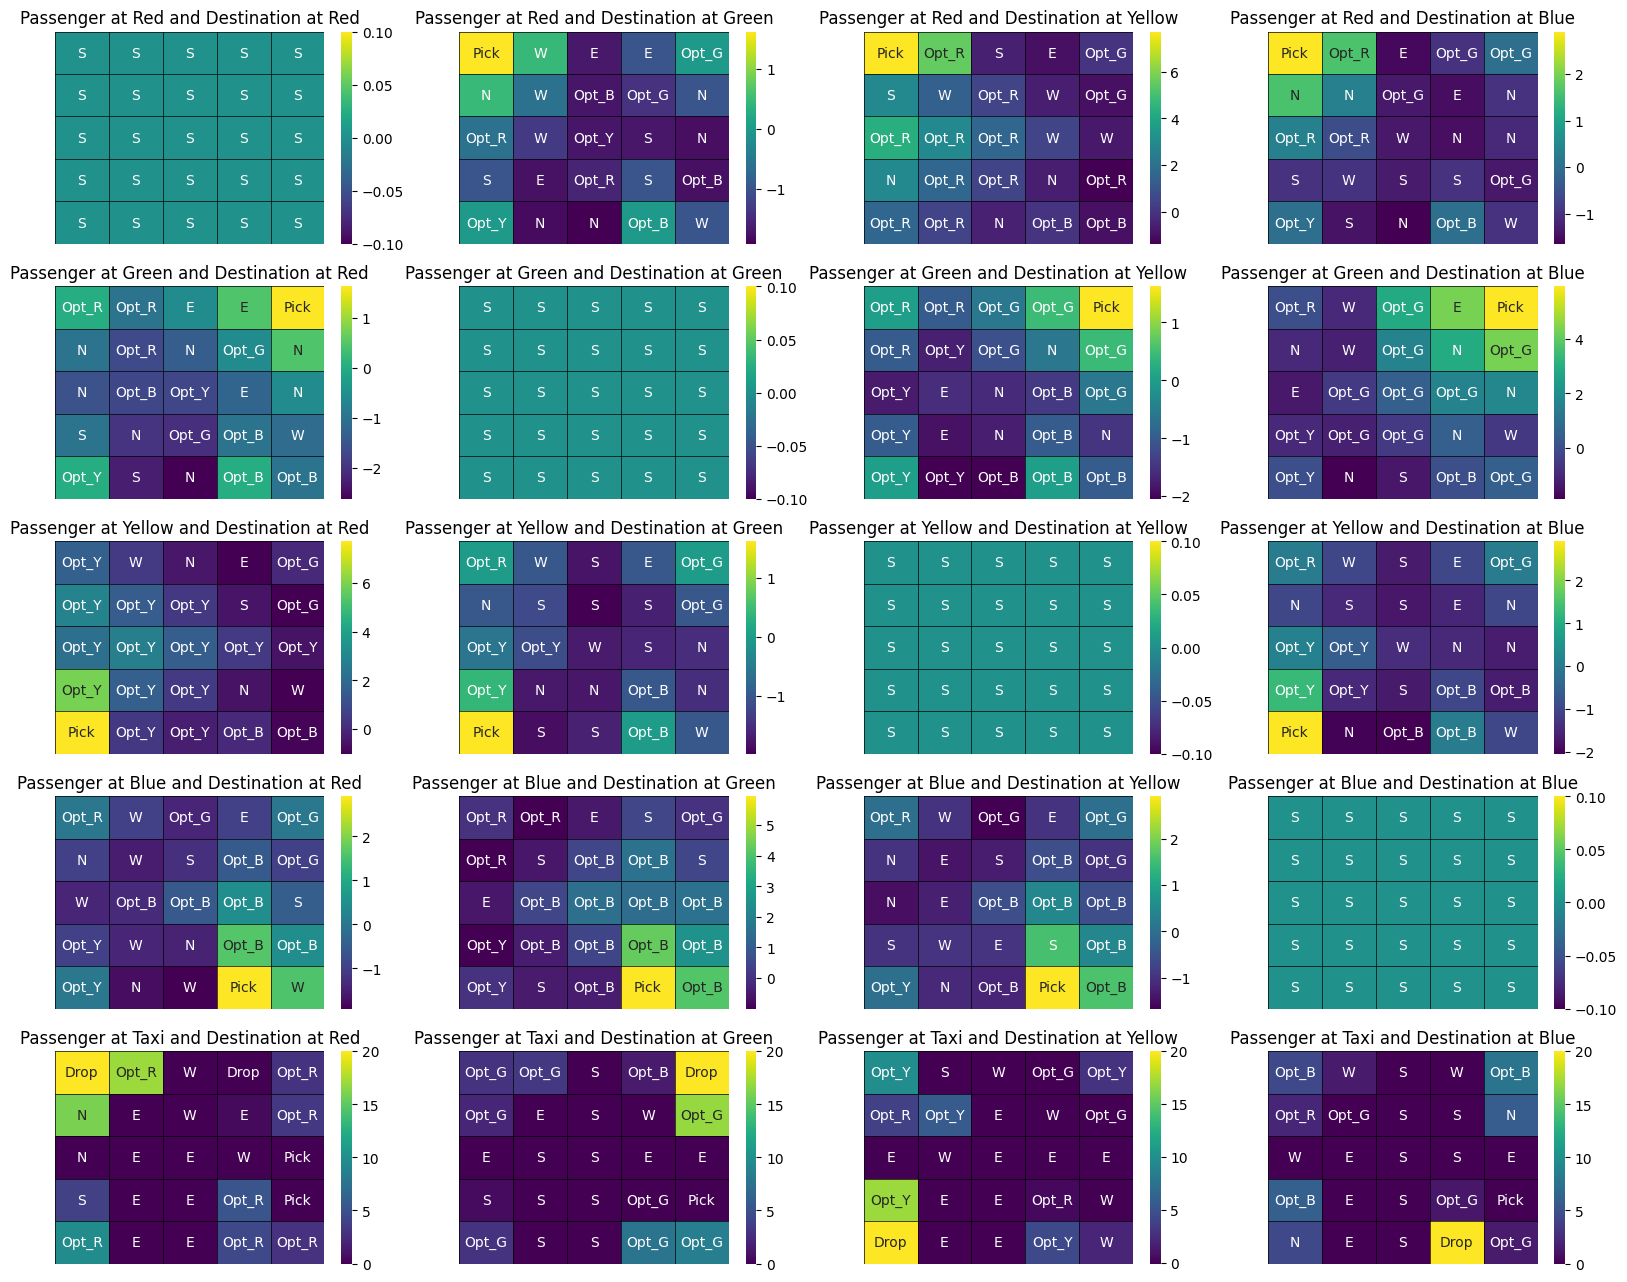

In [ ]:
visualize_q_values(qvalues_tuning_SMDP[5])

## Intra Options Q-Learning :

In [ ]:
class IOQL():
    def __init__(self, total_options, options_object, num_of_episodes, policy, epsilon, gamma, alpha):
        self.total_options = total_options
        self.options_object = options_object
        self.num_of_episodes = num_of_episodes
        self.policy = policy
        self.epsilon = epsilon      # Parameters
        self.gamma = gamma
        self.alpha = alpha

    def run(self):

        state_size = env.observation_space.n                # 500
        option_size = len(self.total_options)               # 10
        q_values_IOQL = np.zeros((state_size, option_size))
        rewards_IOQL = np.zeros(self.num_of_episodes)

        for i in tqdm(range(self.num_of_episodes)):
            state = env.reset()[0]
            done = False
            episodic_reward = 0
            while not done:
                action = self.policy(q_values_IOQL, state, self.epsilon, self.total_options)    # choose action
                if action < 6:
                    # Perform IOQL update for state-action pair
                    next_state, reward, done, _, _ = env.step(action)
                    additional_options = matching_options(state, action, rgyb_policy_dict)
                    for additional_option in additional_options:
                        terminating = terminating_cond(state, additional_option, rgyb_loc_dict)
                        if terminating:   # check terminating condition and perform update accordingly
                            q_values_IOQL[state, additional_option] += self.alpha * (reward + self.gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, additional_option])
                        else:
                            q_values_IOQL[state, additional_option] += self.alpha * (reward + self.gamma * q_values_IOQL[next_state, additional_option] - q_values_IOQL[state, additional_option])

                    episodic_reward += reward
                    state = next_state
                else:
                    # Perform multi-step option update
                    if self.options_object.check_option_execution(state, action, env):
                        state_t, state_t_plus_tau, reward_bar, tau, done = self.options_object.execute_option_IOQL(q_values_IOQL, state, action, env, self.alpha, self.gamma)
                        q_values_IOQL[state_t, action] += self.alpha * (reward_bar + (self.gamma)**tau * np.max(q_values_IOQL[state_t_plus_tau]) - q_values_IOQL[state_t, action])
                        episodic_reward += reward_bar
                        state = state_t_plus_tau
            rewards_IOQL[i] = episodic_reward
        return q_values_IOQL, rewards_IOQL

100%|██████████| 2000/2000 [00:07<00:00, 268.39it/s]


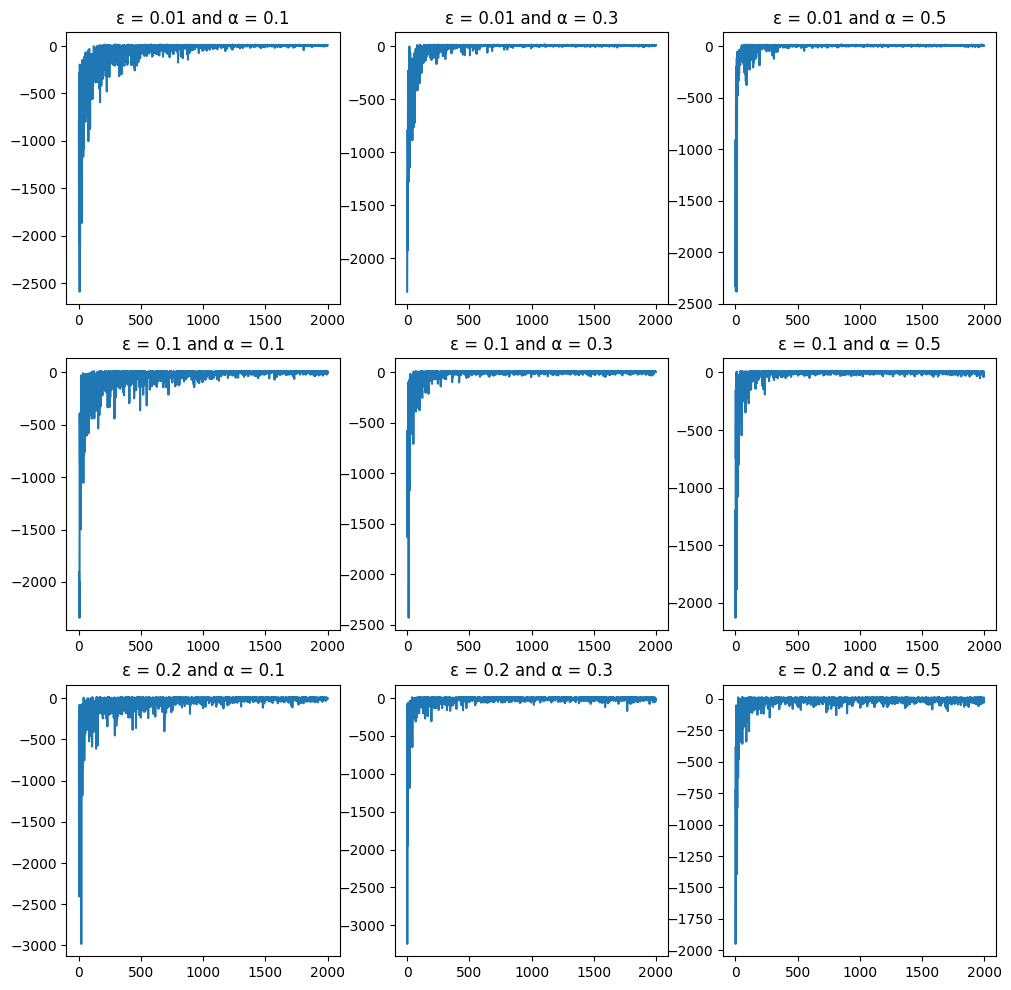

In [ ]:
# Hyperparameter tuning for IOQL
epsilon_values = [0.01, 0.1, 0.2]
alpha_values = [0.1, 0.3, 0.5]
rewards_tuning_IOQL= []
qvalues_tuning_IOQL = []
fig, axes = plt.subplots(3,3, figsize=(12,12))

for (eps,i) in zip(epsilon_values, range(3)):
    for (alp,j) in zip(alpha_values, range(3)):
        ioql = IOQL(total_options, options_object, num_of_episodes, policy, eps, gamma, alp)
        q_values_IOQL, rewards_IOQL = ioql.run()
        qvalues_tuning_IOQL.append(q_values_IOQL)
        rewards_tuning_IOQL.append(rewards_IOQL)
        axes[i][j].plot(rewards_IOQL)
        axes[i][j].set_title('ε = '+str(eps)+' and α = '+str(alp))

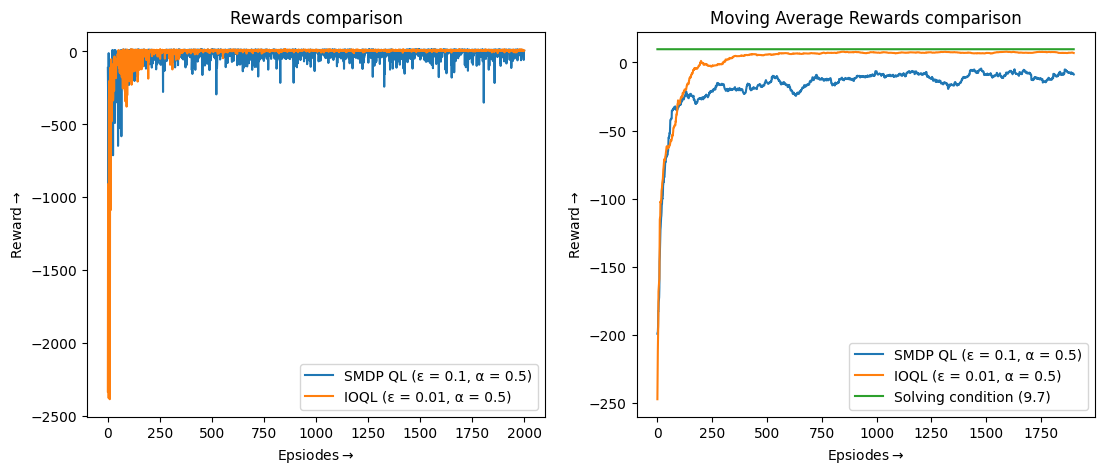

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,5))
axes[0].plot(rewards_tuning_SMDP[5],label = 'SMDP QL (ε = 0.1, α = 0.5)')
axes[0].plot(rewards_tuning_IOQL[2],label = 'IOQL (ε = 0.01, α = 0.5)')
axes[0].set_title('Rewards comparison')
axes[0].set_xlabel(r'Epsiodes$\rightarrow$')
axes[0].set_ylabel(r'Reward$\rightarrow$')
axes[0].legend(loc='best')

running_SMDP = rewards_tuning_SMDP[5]
running_IOQL = rewards_tuning_IOQL[2]
moving_SMDP = []
moving_IOQL = []
for i in range(num_of_episodes - 100):
    window_SMDP = running_SMDP[i:i + 100]
    window_IOQL = running_IOQL[i:i + 100]
    moving_SMDP.append(np.mean(window_SMDP))
    moving_IOQL.append(np.mean(window_IOQL))

axes[1].plot(moving_SMDP,label = 'SMDP QL (ε = 0.1, α = 0.5)')
axes[1].plot(moving_IOQL,label = 'IOQL (ε = 0.01, α = 0.5)')
axes[1].plot([9.7]*(num_of_episodes-100),label='Solving condition (9.7)')
axes[1].set_title('Moving Average Rewards comparison')
axes[1].set_xlabel(r'Epsiodes$\rightarrow$')
axes[1].set_ylabel(r'Reward$\rightarrow$')
axes[1].legend(loc='best')

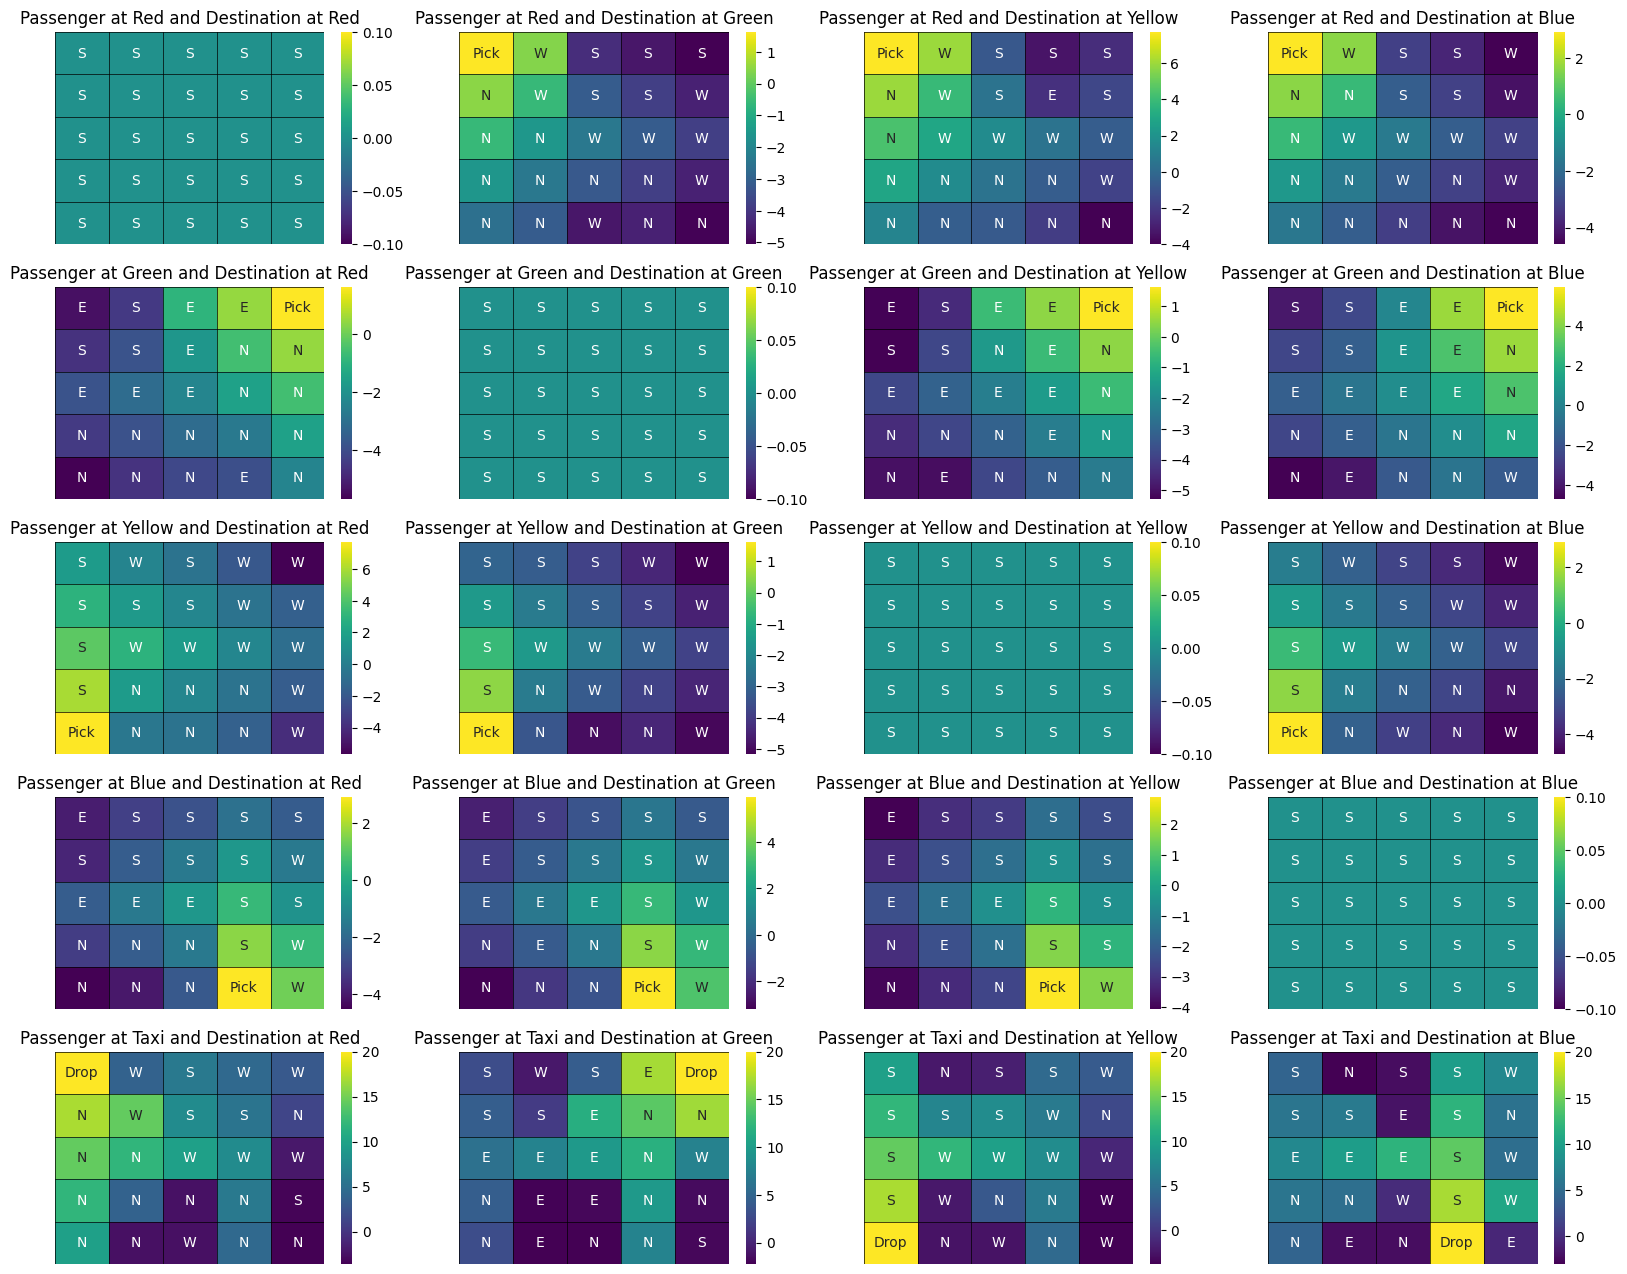

In [ ]:
visualize_q_values(qvalues_tuning_IOQL[2])

## Alternate Options

In [ ]:
# Alternate options to always move South or North or East or West
total_options_alt = ["South", "North", "East", "West", "Pick", "Drop", "Opt_South", "Opt_North", "Opt_East", "Opt_West"]

# Alternate option dictionary for the same
rgyb_policy_dict_alt = {6: np.array([[0,0,0,0,0],
                                      [0,0,0,0,0],
                                      [0,0,0,0,0],
                                      [0,0,0,0,0],
                                      [0,0,0,0,0]]),

                 7: np.array([[1,1,1,1,1],
                              [1,1,1,1,1],
                              [1,1,1,1,1],
                              [1,1,1,1,1],
                              [1,1,1,1,1]]),

                 8: np.array([[2,2,2,2,2],
                              [2,2,2,2,2],
                              [2,2,2,2,2],
                              [2,2,2,2,2],
                              [2,2,2,2,2]]),

                 9: np.array([[3,3,3,3,3],
                              [3,3,3,3,3],
                              [3,3,3,3,3],
                              [3,3,3,3,3],
                              [3,3,3,3,3],])}

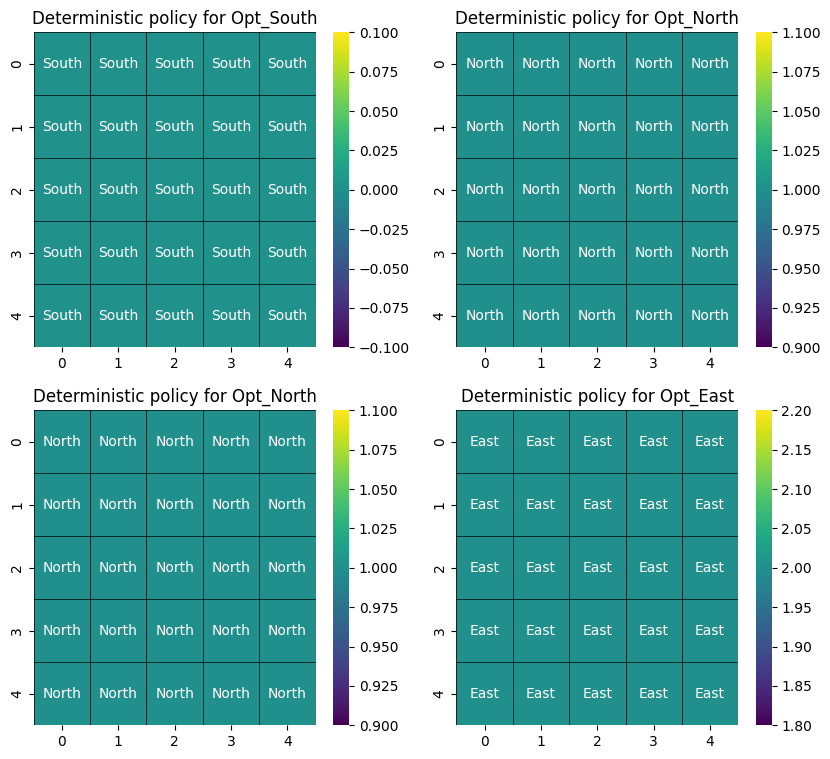

In [ ]:
fig, axes = plt.subplots(2,2,figsize = (10,9))

for i in range(2):
    for j in range(2):
        a = sns.heatmap(rgyb_policy_dict_alt[i+j+6], annot = [[total_options_alt[num] for num in row] for row in rgyb_policy_dict_alt[i+j+6]], ax = axes[i][j],fmt="",cmap='viridis')
        a.set_title('Deterministic policy for '+total_options_alt[i+j+6])
        for k in range(5):
          a.axhline(y=k , color='black', linewidth=0.5)
          a.axvline(x=k , color='black', linewidth=0.5)

In [ ]:
class Options_alt():
    def __init__(self, total_options, rgyb_loc_dict, rgyb_policy_dict):
        self.total_options = total_options
        self.option_size = len(total_options)
        self.rgyb_loc_dict = rgyb_loc_dict
        self.rgyb_policy_dict = rgyb_policy_dict

    def check_option_execution(self, state, option, env):
        '''
        ->Checks if a selected options needs to executed
        ->It need not execute if the taxi is already there at the location
        '''
        taxi_pos1 = list(env.decode(state))[0]
        taxi_pos2 = list(env.decode(state))[1]
        taxi_pos = (taxi_pos1, taxi_pos2)             # Taxi location
        if taxi_pos != self.rgyb_loc_dict[option]:
            return True
        else:
            return False

    def execute_option_SMDP_alt(self, state, option, env, gamma):
        '''
        Multi-step option execution (SMDP)
        '''
        state_t = np.copy(state)
        tau = 0
        reward_bar = 0
        optdone = False
        while (optdone == False):
            taxi_pos1 = list(env.decode(state))[0]
            taxi_pos2 = list(env.decode(state))[1]
            taxi_pos = (taxi_pos1, taxi_pos2)
            optact = self.rgyb_policy_dict[option][taxi_pos1][taxi_pos2]
            next_state, reward, done, _,_ = env.step(optact)
            reward_bar = gamma * reward_bar + reward
            tau += 1
            state = next_state
            next_taxi_pos1 = list(env.decode(state))[0]
            next_taxi_pos2 = list(env.decode(state))[1]
            next_taxi_pos = (next_taxi_pos1, next_taxi_pos2)
            if next_taxi_pos == self.rgyb_loc_dict[option] or next_taxi_pos == taxi_pos:   # Changed the termination condition to also include hitting a wall
                optdone = True
                state_t_plus_tau = state
        return state_t, state_t_plus_tau, reward_bar, tau, done

    def execute_option_IOQL_alt(self, q_values_IOQL, state, option, env, alpha, gamma):
        '''
        Multi-step option execution (IOQL)
        '''
        state_t = np.copy(state)
        tau = 0
        reward_bar = 0
        optdone = False
        while (optdone == False):
            taxi_pos1 = list(env.decode(state))[0]
            taxi_pos2 = list(env.decode(state))[1]
            taxi_pos = (taxi_pos1, taxi_pos2)
            optact = self.rgyb_policy_dict[option][taxi_pos1][taxi_pos2]
            next_state, reward, done, _,_ = env.step(optact)

            additional_options = matching_options(state, optact, self.rgyb_policy_dict)     # would contain additional options from [6,7,8,9]
            for additional_option in additional_options:
                terminating = terminating_cond(state, additional_option, self.rgyb_loc_dict)    # IOQL Update
                if terminating:       # check terminating condition and perform update accordingly
                    q_values_IOQL[state, additional_option] += alpha * (reward + gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, additional_option])
                else:
                    q_values_IOQL[state, additional_option] += alpha * (reward + gamma * q_values_IOQL[next_state, additional_option] - q_values_IOQL[state, additional_option])

            reward_bar = gamma * reward_bar + reward
            tau += 1
            state = next_state
            next_taxi_pos1 = list(env.decode(state))[0]
            next_taxi_pos2 = list(env.decode(state))[1]
            next_taxi_pos = (next_taxi_pos1, next_taxi_pos2)
            if next_taxi_pos == self.rgyb_loc_dict[option] or next_taxi_pos == taxi_pos:    # Changed termination condition to include hitting a wall
                optdone = True
                state_t_plus_tau = state

        return state_t, state_t_plus_tau, reward_bar, tau, done


## SMDP Alternate

In [ ]:
class SMDP_QL_alt():
    def __init__(self, total_options, options_object, num_of_episodes, policy, epsilon, gamma, alpha):
        self.total_options = total_options
        self.options_object = options_object
        self.num_of_episodes = num_of_episodes
        self.policy = policy
        self.epsilon = epsilon        # Parameters
        self.gamma = gamma
        self.alpha = alpha

    def run(self):

        state_size = env.observation_space.n                # 500
        option_size = len(self.total_options)               # 10
        q_values_SMDP = np.zeros((state_size, option_size))
        rewards_SMDP = np.zeros(self.num_of_episodes)

        for i in tqdm(range(self.num_of_episodes)):
            state = env.reset()[0]
            done = False
            episodic_reward = 0
            while not done:
                action = self.policy(q_values_SMDP, state, self.epsilon, self.total_options)      # Choose action
                if action < 6:
                    # Perform regular Q-Learning update for state-action pair
                    next_state, reward, done, _, _ = env.step(action)
                    q_values_SMDP[state, action] += self.alpha * (reward + self.gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, action])
                    episodic_reward += reward
                    state = next_state
                else:
                    # Perform multi-step option update
                    if self.options_object.check_option_execution(state, action, env):
                        state_t, state_t_plus_tau, reward_bar, tau, done = self.options_object.execute_option_SMDP_alt(state, action, env, self.gamma)
                        q_values_SMDP[state_t, action] += self.alpha * (reward_bar + (self.gamma)**tau * np.max(q_values_SMDP[state_t_plus_tau]) - q_values_SMDP[state_t, action])
                        episodic_reward += reward_bar
                        state = state_t_plus_tau
            rewards_SMDP[i] = episodic_reward
        return q_values_SMDP, rewards_SMDP

In [ ]:
options_object_alt = Options_alt(total_options, rgyb_loc_dict, rgyb_policy_dict_alt)
num_of_episodes = 2000
policy = egreedy_policy
gamma = 0.9
epsilon = 0.1
alpha = 0.5

In [ ]:
smdp_alt = SMDP_QL_alt(total_options, options_object_alt, num_of_episodes, policy, epsilon, gamma, alpha)
q_values_SMDP_alt, rewards_SMDP_alt = smdp_alt.run()

100%|██████████| 2000/2000 [33:43<00:00,  1.01s/it]


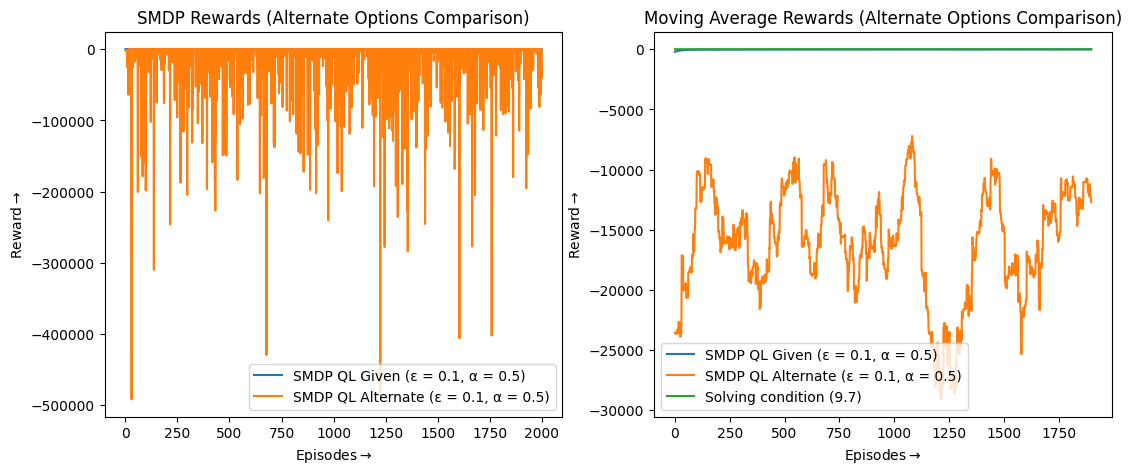

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,5))
axes[0].plot(rewards_tuning_SMDP[5],label = 'SMDP QL Given (ε = 0.1, α = 0.5)')
axes[0].plot(rewards_SMDP_alt,label = 'SMDP QL Alternate (ε = 0.1, α = 0.5)')
axes[0].set_title('SMDP Rewards (Alternate Options Comparison)')
axes[0].set_xlabel(r'Episodes$\rightarrow$')
axes[0].set_ylabel(r'Reward$\rightarrow$')
axes[0].legend(loc='best')

running_SMDP_alt = rewards_SMDP_alt
moving_SMDP_alt = []
for i in range(num_of_episodes - 100):
    window_SMDP_alt = running_SMDP_alt[i:i + 100]
    moving_SMDP_alt.append(np.mean(window_SMDP_alt))

axes[1].plot(moving_SMDP,label = 'SMDP QL Given (ε = 0.1, α = 0.5)')
axes[1].plot(moving_SMDP_alt,label = 'SMDP QL Alternate (ε = 0.1, α = 0.5)')
axes[1].plot([9.7]*(num_of_episodes-100),label='Solving condition (9.7)')
axes[1].set_title('Moving Average Rewards (Alternate Options Comparison)')
axes[1].set_xlabel(r'Episodes$\rightarrow$')
axes[1].set_ylabel(r'Reward$\rightarrow$')
axes[1].legend(loc='best')

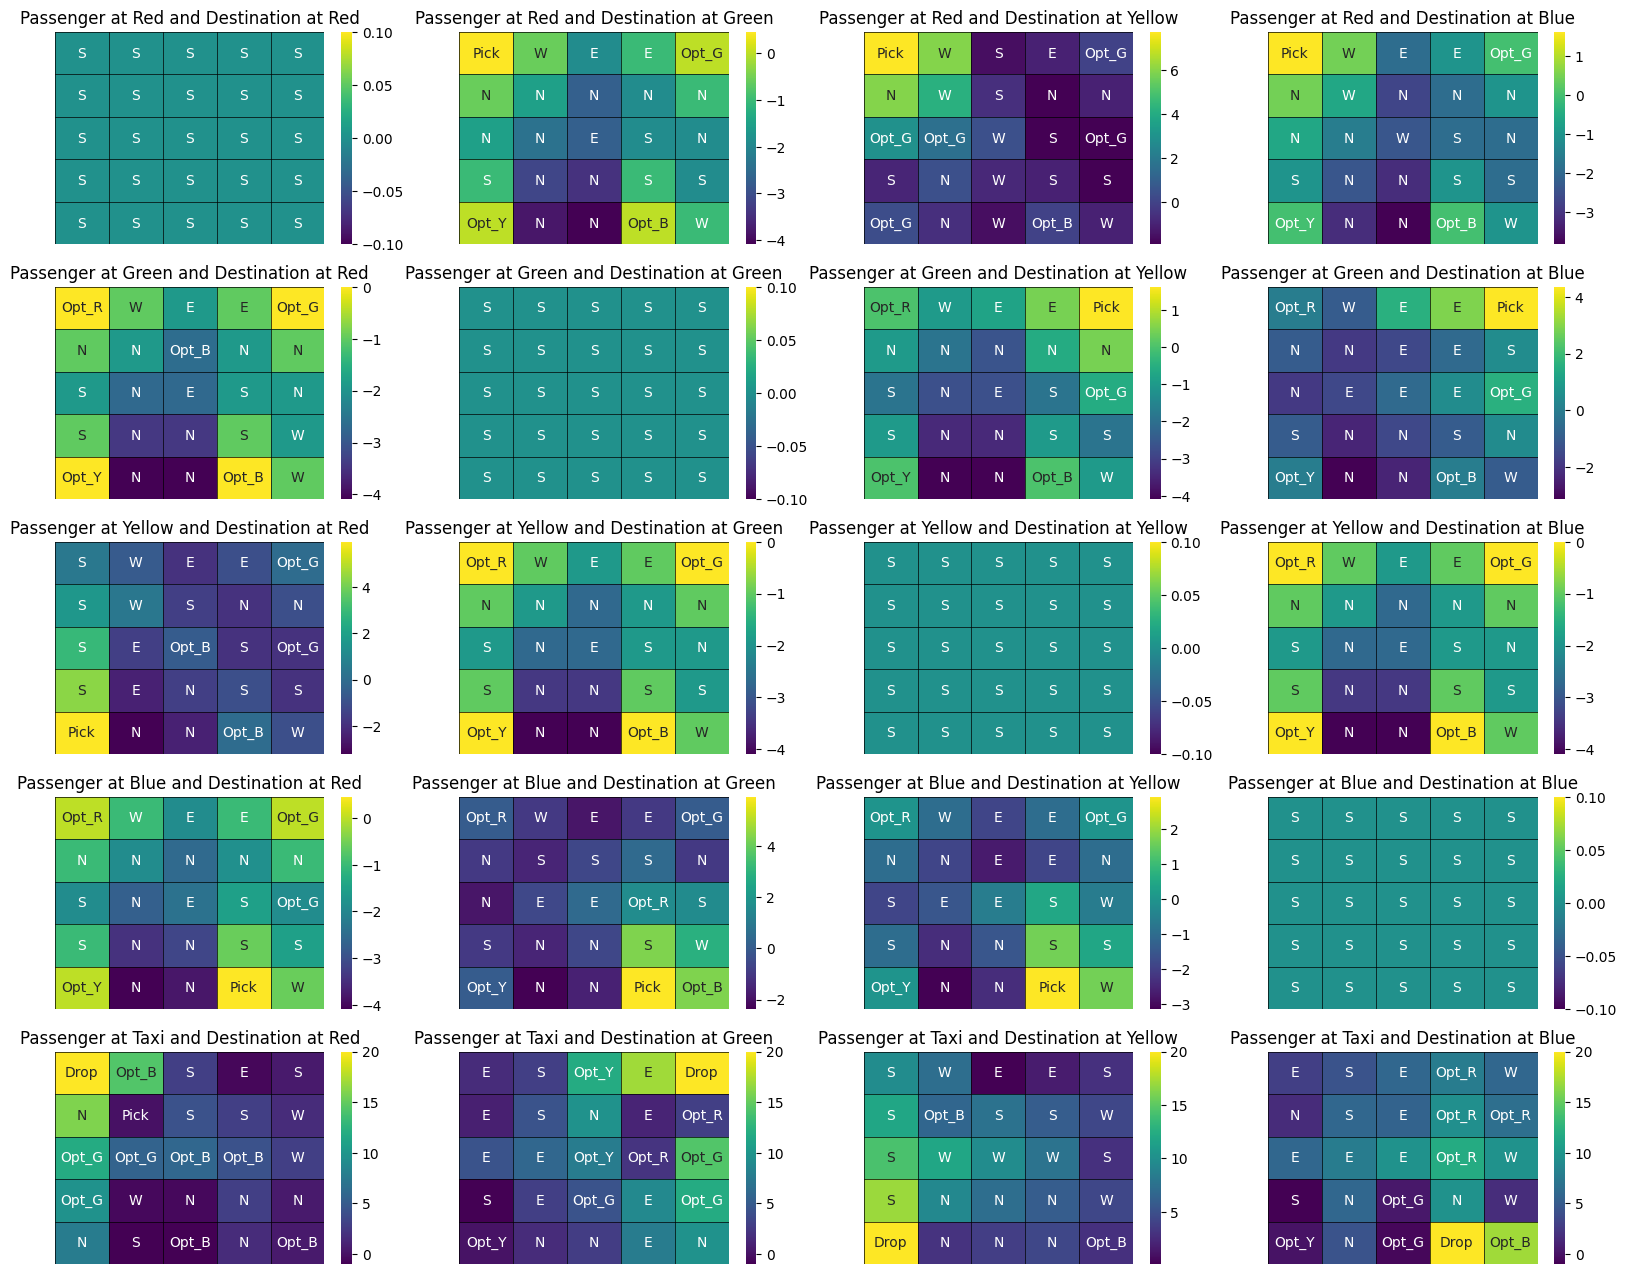

In [ ]:
visualize_q_values(q_values_SMDP_alt)

## IOQL Alternate

In [ ]:
class IOQL_alt():
    def __init__(self, total_options, options_object, num_of_episodes, policy, epsilon, gamma, alpha):
        self.total_options = total_options
        self.options_object = options_object
        self.num_of_episodes = num_of_episodes
        self.policy = policy
        self.epsilon = epsilon      # Parameters
        self.gamma = gamma
        self.alpha = alpha

    def run(self):

        state_size = env.observation_space.n                # 500
        option_size = len(self.total_options)               # 10
        q_values_IOQL = np.zeros((state_size, option_size))
        rewards_IOQL = np.zeros(self.num_of_episodes)

        for i in tqdm(range(self.num_of_episodes)):
            state = env.reset()[0]
            done = False
            episodic_reward = 0
            while not done:
                action = self.policy(q_values_IOQL, state, self.epsilon, self.total_options)    # choose action
                if action < 6:
                    # Perform IOQL update for state-action pair
                    next_state, reward, done, _, _ = env.step(action)
                    additional_options = matching_options(state, action, rgyb_policy_dict_alt)
                    for additional_option in additional_options:
                        terminating = terminating_cond(state, additional_option, rgyb_loc_dict)
                        if terminating:   # check terminating condition and perform update accordingly
                            q_values_IOQL[state, additional_option] += self.alpha * (reward + self.gamma * np.max(q_values_IOQL[next_state]) - q_values_IOQL[state, additional_option])
                        else:
                            q_values_IOQL[state, additional_option] += self.alpha * (reward + self.gamma * q_values_IOQL[next_state, additional_option] - q_values_IOQL[state, additional_option])

                    episodic_reward += reward
                    state = next_state
                else:
                    # Perform multi-step option update
                    if self.options_object.check_option_execution(state, action, env):
                        state_t, state_t_plus_tau, reward_bar, tau, done = self.options_object.execute_option_IOQL_alt(q_values_IOQL, state, action, env, self.alpha, self.gamma)
                        q_values_IOQL[state_t, action] += self.alpha * (reward_bar + (self.gamma)**tau * np.max(q_values_IOQL[state_t_plus_tau]) - q_values_IOQL[state_t, action])
                        episodic_reward += reward_bar
                        state = state_t_plus_tau
            rewards_IOQL[i] = episodic_reward
        return q_values_IOQL, rewards_IOQL

In [ ]:
epsilon=0.01

In [ ]:
ioql_alt = IOQL_alt(total_options_alt, options_object_alt, num_of_episodes, policy, epsilon, gamma, alpha)
q_values_IOQL_alt, rewards_IOQL_alt = ioql_alt.run()

100%|██████████| 2000/2000 [00:04<00:00, 423.63it/s]


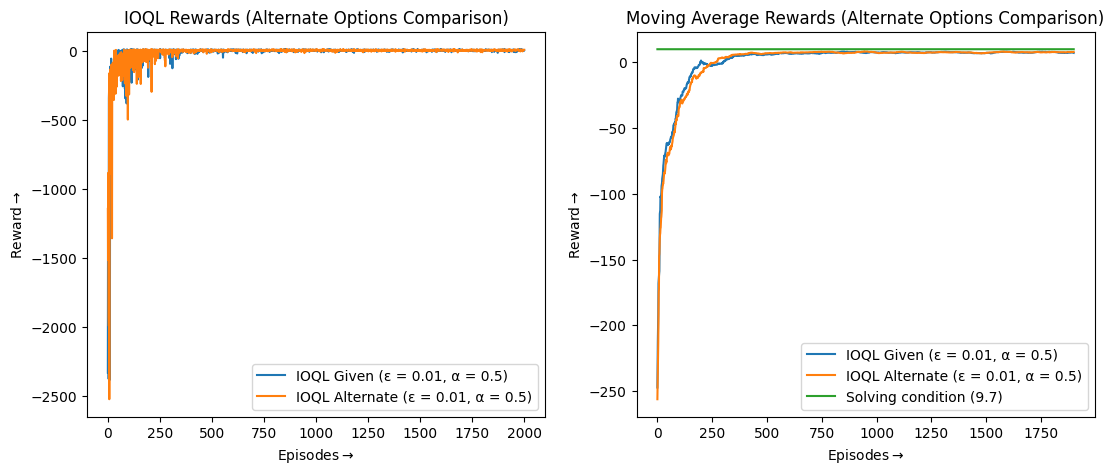

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,5))
axes[0].plot(rewards_tuning_IOQL[2],label = 'IOQL Given (ε = 0.01, α = 0.5)')
axes[0].plot(rewards_IOQL_alt,label = 'IOQL Alternate (ε = 0.01, α = 0.5)')
axes[0].set_title('IOQL Rewards (Alternate Options Comparison)')
axes[0].set_xlabel(r'Episodes$\rightarrow$')
axes[0].set_ylabel(r'Reward$\rightarrow$')
axes[0].legend(loc='best')

running_IOQL_alt = rewards_IOQL_alt
moving_IOQL_alt = []
for i in range(num_of_episodes - 100):
    window_IOQL_alt = running_IOQL_alt[i:i + 100]
    moving_IOQL_alt.append(np.mean(window_IOQL_alt))

axes[1].plot(moving_IOQL,label = 'IOQL Given (ε = 0.01, α = 0.5)')
axes[1].plot(moving_IOQL_alt,label = 'IOQL Alternate (ε = 0.01, α = 0.5)')
axes[1].plot([9.7]*(num_of_episodes-100),label='Solving condition (9.7)')
axes[1].set_title('Moving Average Rewards (Alternate Options Comparison)')
axes[1].set_xlabel(r'Episodes$\rightarrow$')
axes[1].set_ylabel(r'Reward$\rightarrow$')
axes[1].legend(loc='best')

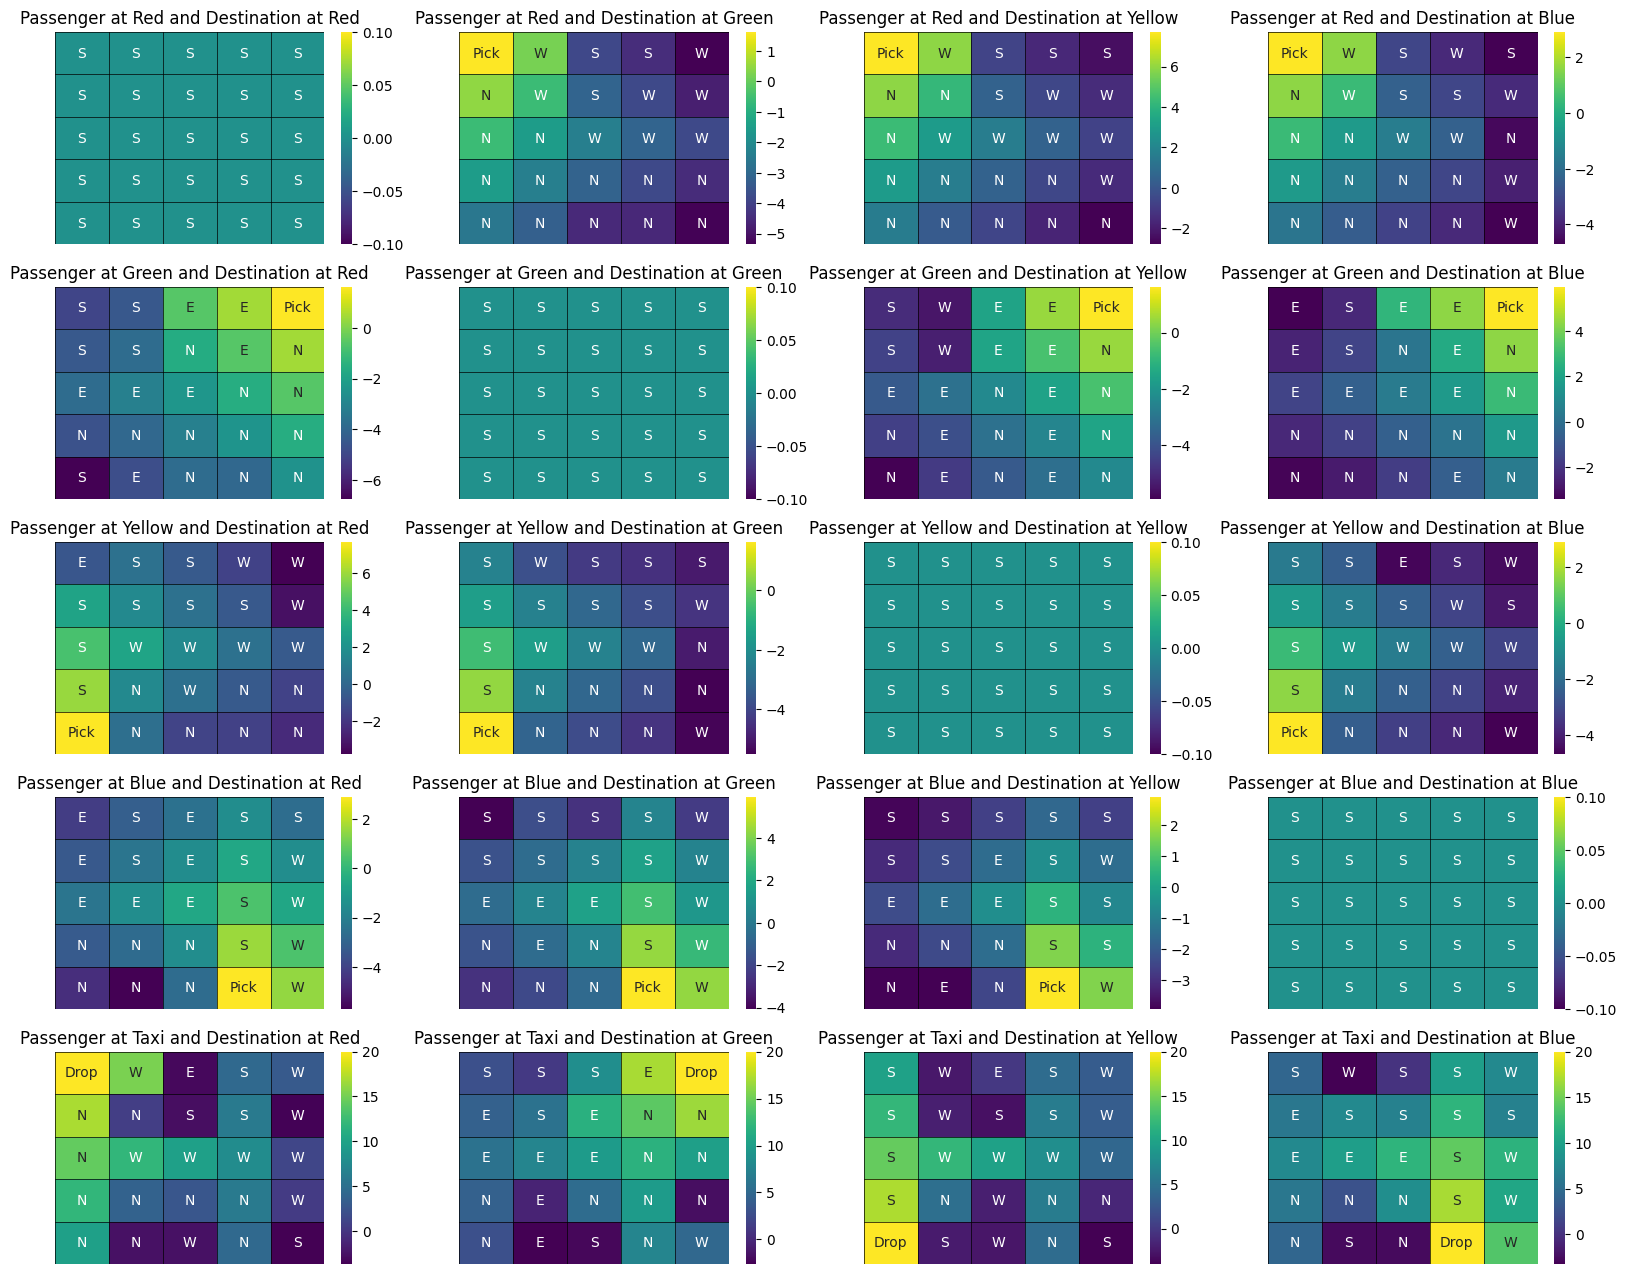

In [ ]:
visualize_q_values(q_values_IOQL_alt)

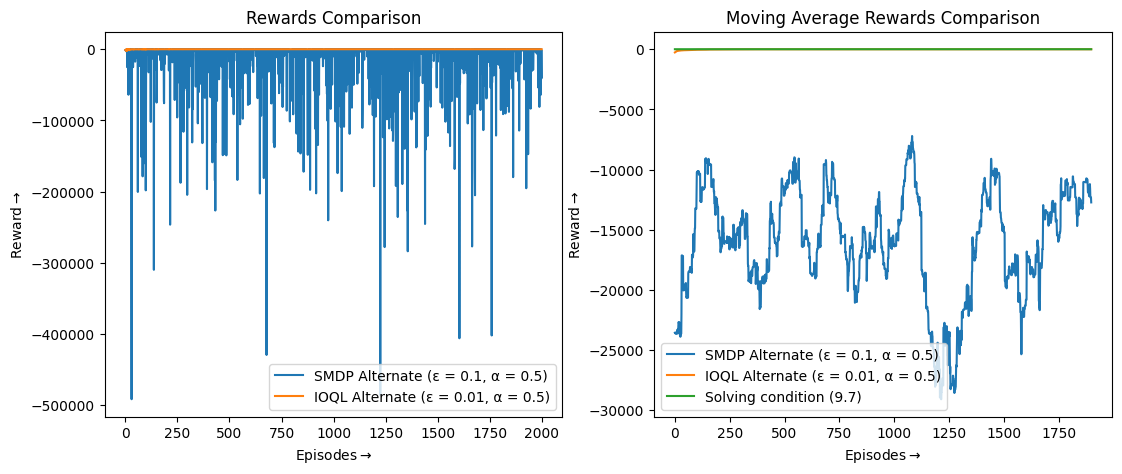

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,5))
axes[0].plot(rewards_SMDP_alt,label = 'SMDP Alternate (ε = 0.1, α = 0.5)')
axes[0].plot(rewards_IOQL_alt,label = 'IOQL Alternate (ε = 0.01, α = 0.5)')
axes[0].set_title('Rewards Comparison')
axes[0].set_xlabel(r'Episodes$\rightarrow$')
axes[0].set_ylabel(r'Reward$\rightarrow$')
axes[0].legend(loc='best')

axes[1].plot(moving_SMDP_alt,label = 'SMDP Alternate (ε = 0.1, α = 0.5)')
axes[1].plot(moving_IOQL_alt,label = 'IOQL Alternate (ε = 0.01, α = 0.5)')
axes[1].plot([9.7]*(num_of_episodes-100),label='Solving condition (9.7)')
axes[1].set_title('Moving Average Rewards Comparison')
axes[1].set_xlabel(r'Episodes$\rightarrow$')
axes[1].set_ylabel(r'Reward$\rightarrow$')
axes[1].legend(loc='best')